In [1]:
import pandas as pd

# Load the datasets
file1 = '../data/processed/cleaned_dataset_v44.csv'
file2 = '../data/processed/cleaned_data.csv'

df1 = pd.read_csv(file1)  # Cleaned independent variables
df2 = pd.read_csv(file2)  # Original dataset with target variables


In [2]:
# Rename unique key for merging consistency
df1.rename(columns={'Unnamed: 0': 'Unique_Key'}, inplace=True)
df2['Unique_Key'] = range(1, len(df2) + 1)


## Merge the dependent variables and three columns with the dataset after transforming the independent variables

In [4]:
# Keep only relevant columns from df2
df2 = df2[['Unique_Key', 'Province', 'YEAR', 'QUARTER', 
           'Excellent_Very_Good', 'Good', 'Fair_Poor']]


In [5]:
# Merge based on Unique_Key
combined_df = pd.merge(df1, df2, on='Unique_Key', how='inner')


In [6]:
# Save the cleaned dataset
output_file = '../data/processed/cleaned_dataset_v55.csv'
combined_df.to_csv(output_file, index=False)

print(f"Combined dataset saved as '{output_file}'")


Combined dataset saved as '../data/processed/cleaned_dataset_v55.csv'


## ACF and PACF Plots

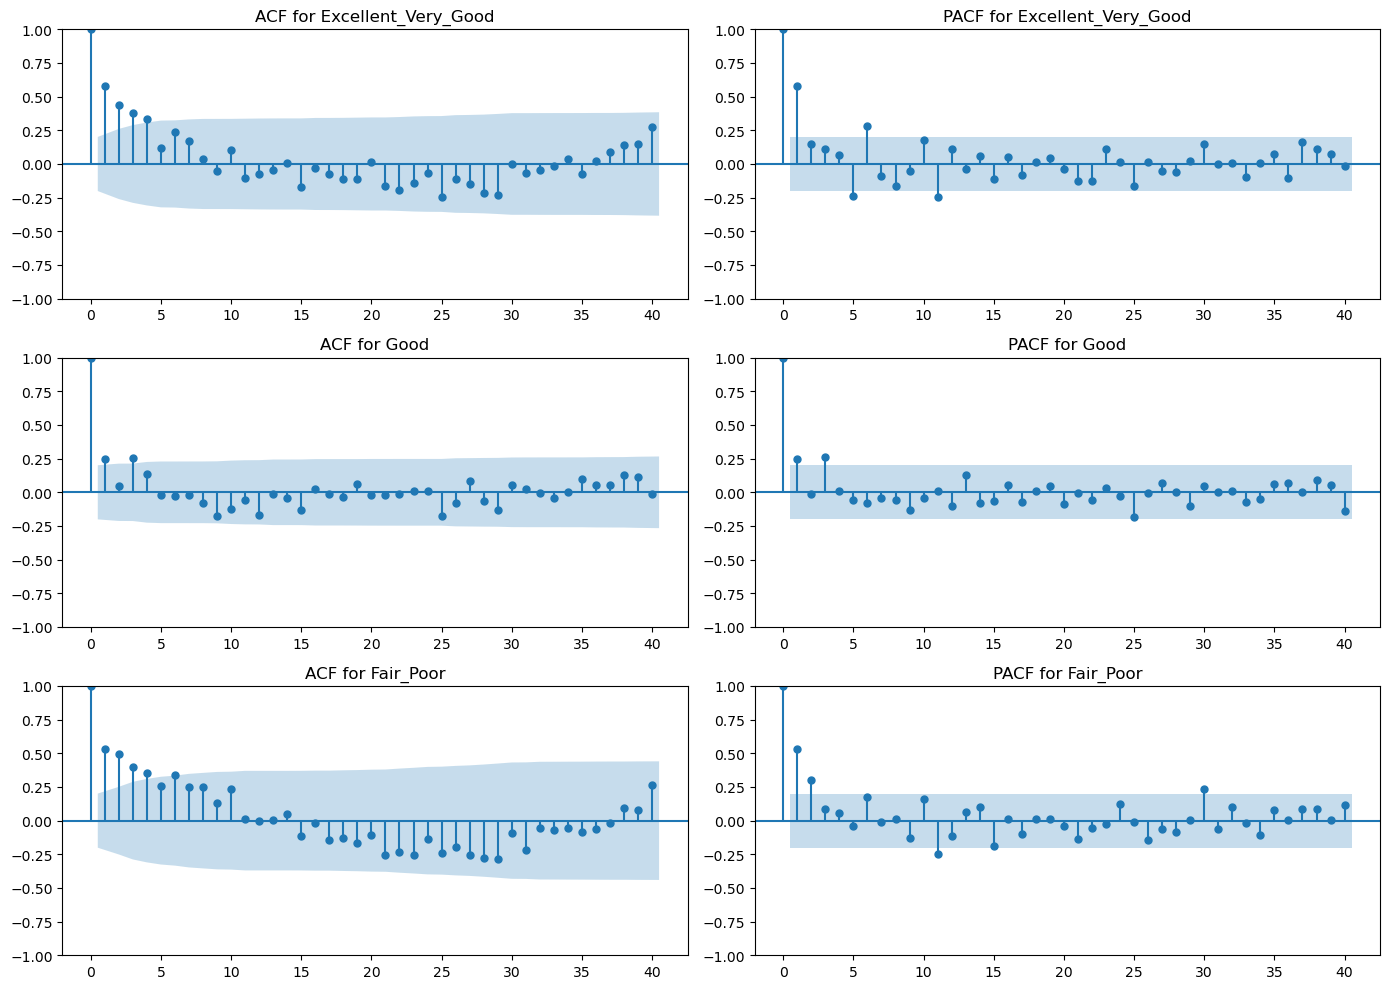

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the combined dataset (only once)
file_path = '../data/processed/cleaned_dataset_v55.csv'
df = pd.read_csv(file_path)

# List of target variables
target_variables = ['Excellent_Very_Good', 'Good', 'Fair_Poor']

# Plot ACF and PACF for each target variable
fig, axes = plt.subplots(len(target_variables), 2, figsize=(14, 10))

for i, target in enumerate(target_variables):
    data = df[target].dropna()
    
    # ACF plot
    plot_acf(data, lags=40, ax=axes[i, 0])
    axes[i, 0].set_title(f'ACF for {target}')
    
    # PACF plot (add 'ywm' method to avoid warnings)
    plot_pacf(data, lags=40, ax=axes[i, 1], method='ywm')
    axes[i, 1].set_title(f'PACF for {target}')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## Stationarity Check for Three Dependent Variables

In [10]:
from statsmodels.tsa.stattools import adfuller

# Function to test for stationarity
def test_stationarity(series, name):
    result = adfuller(series.dropna())
    print(f"\n{name} Stationarity Test:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"{key}: {value}")
    if result[1] <= 0.05:
        print(f"✅ {name} is stationary (p-value <= 0.05)")
    else:
        print(f"❌ {name} is NOT stationary (p-value > 0.05)")

# Test for each target variable
for target in target_variables:
    test_stationarity(df[target], target)



Excellent_Very_Good Stationarity Test:
ADF Statistic: -2.7246433668856795
p-value: 0.06987010461179487
Critical Values:
1%: -3.510711795769895
5%: -2.8966159448223734
10%: -2.5854823866213152
❌ Excellent_Very_Good is NOT stationary (p-value > 0.05)

Good Stationarity Test:
ADF Statistic: -3.5167999666167953
p-value: 0.007565973553204482
Critical Values:
1%: -3.503514579651927
5%: -2.893507960466837
10%: -2.583823615311909
✅ Good is stationary (p-value <= 0.05)

Fair_Poor Stationarity Test:
ADF Statistic: -3.358687296120129
p-value: 0.01245047261644581
Critical Values:
1%: -3.502704609582561
5%: -2.8931578098779522
10%: -2.583636712914788
✅ Fair_Poor is stationary (p-value <= 0.05)


### Apply first differencing for Excellent_Very_Good

In [12]:
# Apply first differencing for Excellent_Very_Good
df['Excellent_Very_Good_diff'] = df['Excellent_Very_Good'].diff().dropna()


In [13]:
# Test for stationarity after differencing
test_stationarity(df['Excellent_Very_Good_diff'], 'Excellent_Very_Good (Differenced)')



Excellent_Very_Good (Differenced) Stationarity Test:
ADF Statistic: -3.3974275609716855
p-value: 0.011046879091396131
Critical Values:
1%: -3.5117123057187376
5%: -2.8970475206326833
10%: -2.5857126912469153
✅ Excellent_Very_Good (Differenced) is stationary (p-value <= 0.05)


In [14]:
#Dickey-Fuller test for stationarity is applied to target (dependent) variables

## Fit ARIMA for Excellent_Very_Good

                                SARIMAX Results                                
Dep. Variable:     Excellent_Very_Good   No. Observations:                   76
Model:                  ARIMA(1, 1, 0)   Log Likelihood                -216.602
Date:                 Tue, 01 Apr 2025   AIC                            437.204
Time:                         17:15:52   BIC                            441.839
Sample:                              0   HQIC                           439.055
                                  - 76                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4018      0.112     -3.586      0.000      -0.621      -0.182
sigma2        18.8371      3.137      6.004      0.000      12.688      24.986
Ljung-Box (L1) (Q):                   1.33  

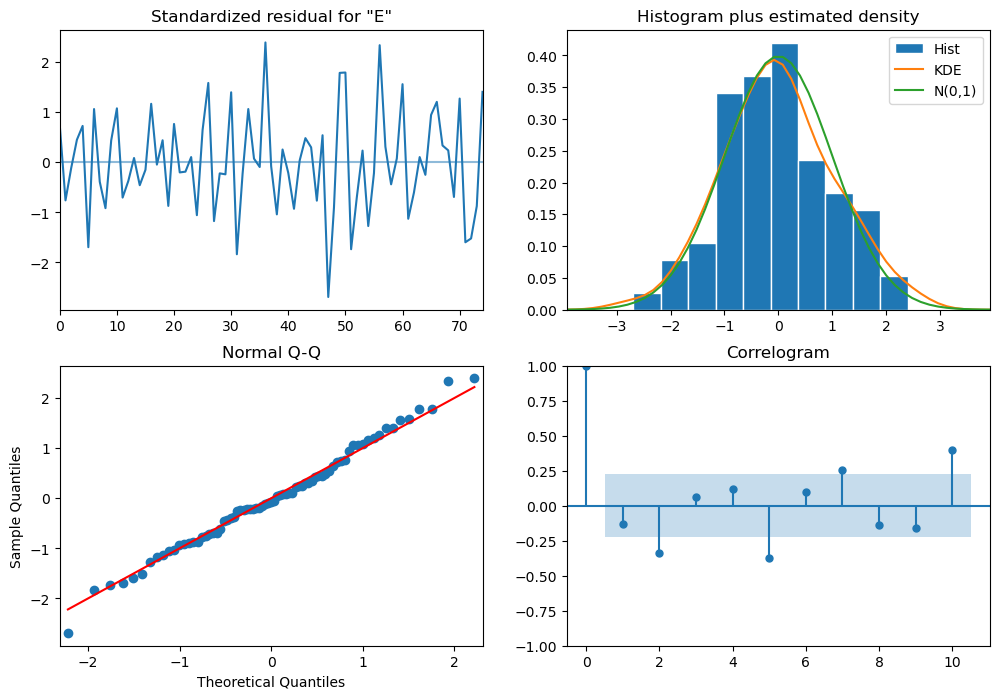

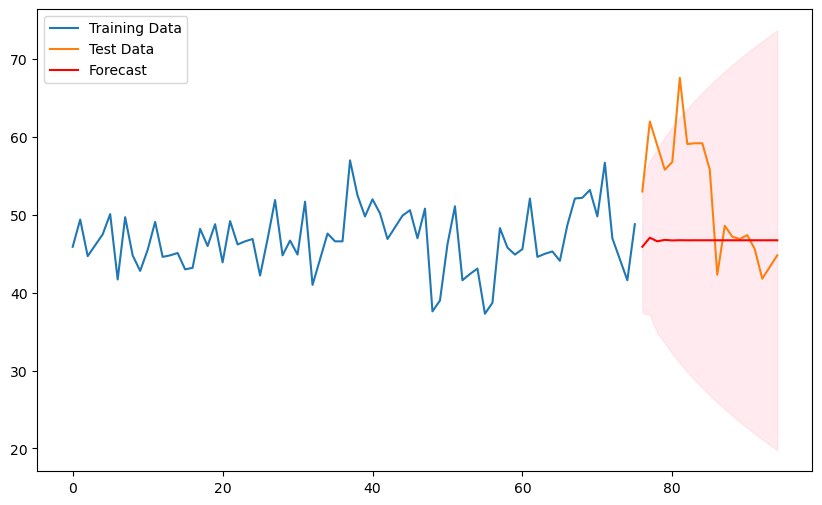

In [16]:
# Fit ARIMA for Excellent_Very_Good

# Suggested Model: ARIMA(1, 1, 0) → Based on the sharp PACF cutoff and gradual ACF decay.

from statsmodels.tsa.arima.model import ARIMA

# Split 80% for training, 20% for testing
train_size = int(len(df['Excellent_Very_Good']) * 0.8)
train, test = df['Excellent_Very_Good'][:train_size], df['Excellent_Very_Good'][train_size:]

# Fit ARIMA model on training data
model = ARIMA(train.dropna(), order=(1, 1, 0))
result = model.fit()

# Display model summary
print(result.summary())

# Plot residual diagnostics
result.plot_diagnostics(figsize=(12, 8))
plt.show()

# Forecast using the test set
forecast = result.get_forecast(steps=len(test))
forecast_ci = forecast.conf_int()

# Plot forecast vs actual
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()


In [17]:
print(train.head())
print(test.head())

0    45.9
1    49.4
2    44.7
3    46.1
4    47.5
Name: Excellent_Very_Good, dtype: float64
76    53.0
77    62.0
78    58.9
79    55.8
80    56.8
Name: Excellent_Very_Good, dtype: float64


## Check if seasonality is present
### If seasonality is weak or absent, SARIMA won’t improve the model

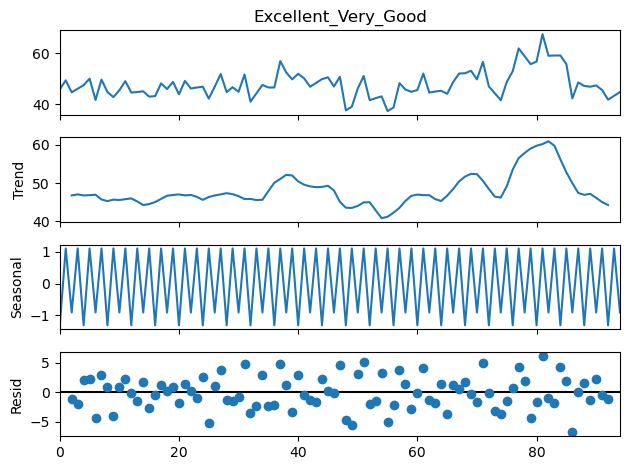

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
result = seasonal_decompose(df['Excellent_Very_Good'].dropna(), model='additive', period=4) # period=4 for quarterly data

# Plot the decomposition
result.plot()
plt.show()


In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Test for autocorrelation in residuals
ljung_box = acorr_ljungbox(result.resid.dropna(), lags=[4, 8, 12], return_df=True)
print(ljung_box)


       lb_stat     lb_pvalue
4    40.138501  4.052139e-08
8    77.255625  1.741189e-13
12  104.424404  7.533464e-17


In [21]:
# p-value ≤ 0.05 at lags 4, 8, and 12 → Strong evidence of seasonality.
# The repeating pattern in the lags suggests that seasonality is present — especially since this is quarterly data (seasonality at lag 4).
# This confirms that SARIMA is appropriate for Excellent_Very_Good.

## Fit SARIMA for Excellent_Very_Good

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84774D+00    |proj g|=  8.88449D-02

At iterate    5    f=  2.84202D+00    |proj g|=  7.26208D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   7.935D-07   2.842D+00
  F =   2.8420229657173470     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                     
Dep. Variable:               Excellent_Ver

 This problem is unconstrained.


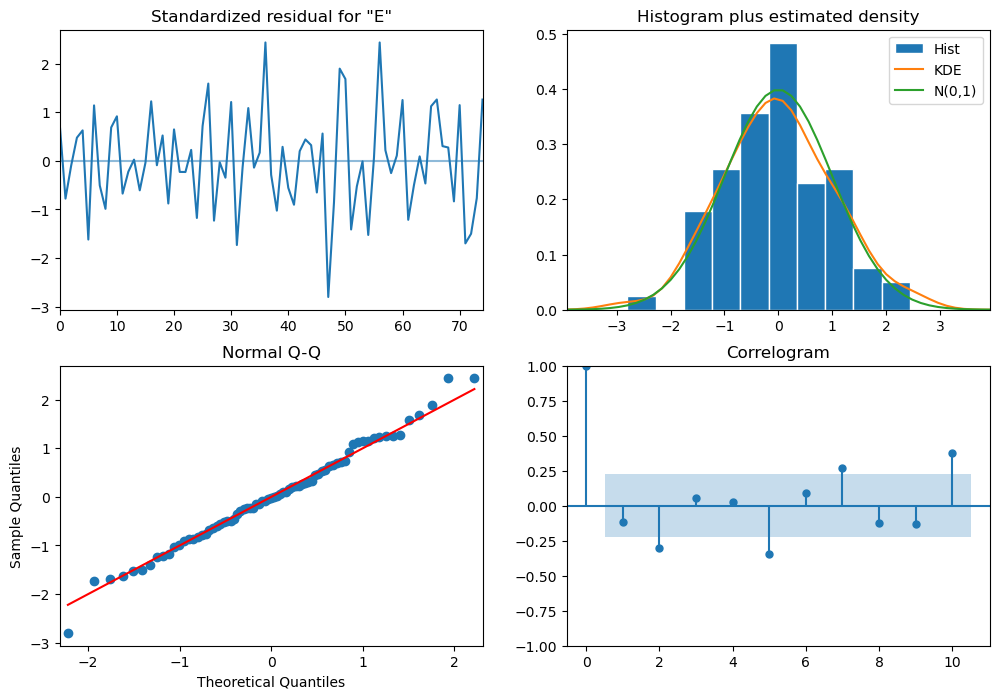

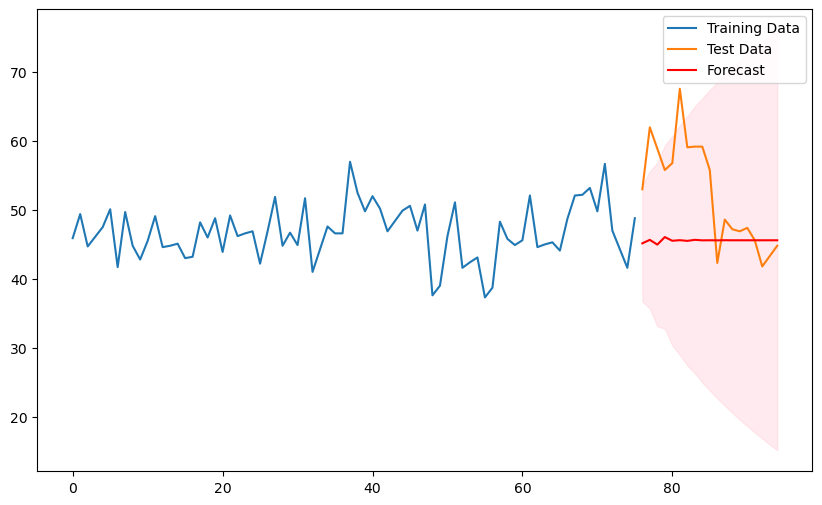

In [23]:
# Fit SARIMA
# try SARIMA with: (1, 1, 0) → Based on ACF/PACF for AR and MA terms; (1, 0, 0, 4) → Quarterly seasonality

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Split 80% for training, 20% for testing
train_size = int(len(df['Excellent_Very_Good']) * 0.8)
train, test = df['Excellent_Very_Good'][:train_size], df['Excellent_Very_Good'][train_size:]

# Fit SARIMA model on training data
model = SARIMAX(train.dropna(),
                order=(1, 1, 0),                # ARIMA structure
                seasonal_order=(1, 0, 0, 4))    # Quarterly seasonality

result = model.fit()

# Display model summary
print(result.summary())

# Plot residual diagnostics
result.plot_diagnostics(figsize=(12, 8))
plt.show()

# Forecast using the test set
forecast = result.get_forecast(steps=len(test))
forecast_ci = forecast.conf_int()

# Plot forecast vs actual
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()


## Fit SARIMAX for Excellent_Very_Good

In [25]:
# Try for SARIMAX 
# Select independent variables
independent_vars = [
    'Quarterly Avg Temp (°C)',
    'Quarterly Sum Precip (mm)',
    'CPI Average',
    'CPI value Cumulative',
    'CPI Compounded',
    'Debt_to_Asset_Ratio',
    'Mortgage_Debt_to_Real_Estate_Ratio',
    'Depression',
    'Anxiety',
    'Therapy',
    'Stress',
    'Unemployment Rate'
]

# Split exogenous variables for training and test sets
exog_train = df[independent_vars].iloc[:len(train)]
exog_test = df[independent_vars].iloc[len(train):]


KeyError: "None of [Index(['Quarterly Avg Temp (°C)', 'Quarterly Sum Precip (mm)', 'CPI Average',\n       'CPI value Cumulative', 'CPI Compounded', 'Debt_to_Asset_Ratio',\n       'Mortgage_Debt_to_Real_Estate_Ratio', 'Depression', 'Anxiety',\n       'Therapy', 'Stress', 'Unemployment Rate'],\n      dtype='object')] are in the [columns]"

In [26]:
df.head

<bound method NDFrame.head of     Unnamed: 0.1  Unique_Key  Quarterly Sum Precip (mm)_diff  \
0              5           5                       -0.607860   
1              6           6                        0.376481   
2              7           7                        0.374891   
3              8           8                       -1.076561   
4              9           9                        0.052778   
..           ...         ...                             ...   
90            95          95                       -0.127807   
91            96          96                        0.667502   
92            97          97                       -0.290922   
93            98          98                       -0.775338   
94            99          99                        0.154776   

    CPI Compounded_diff  Debt_to_Asset_Ratio_diff  \
0             -0.520369                  0.006551   
1             -0.039898                  0.014486   
2             -0.651110                  0

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Updated independent variables
exog_vars = [
    'Quarterly Sum Precip (mm)_diff',
    'CPI Compounded_diff',
    'Debt_to_Asset_Ratio_diff',
    'Mortgage_Debt_to_Real_Estate_Ratio_diff',
    'Depression_diff',
    'Anxiety_diff',
    'Stress_diff',
    'Unemployment Rate_diff',
    'Quarterly Avg Temp (°C)_diff',
    'Therapy_diff2'
]

In [30]:
# Split 80% for training, 20% for testing
train_size = int(len(df['Excellent_Very_Good']) * 0.8)
train, test = df['Excellent_Very_Good'][:train_size], df['Excellent_Very_Good'][train_size:]

# Split exogenous variables for training and test sets
exog_train = df[exog_vars].iloc[:train_size]
exog_test = df[exog_vars].iloc[train_size:]


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74285D+00    |proj g|=  8.89762D-02

At iterate    5    f=  2.72781D+00    |proj g|=  3.62870D-02

At iterate   10    f=  2.72029D+00    |proj g|=  6.74374D-03

At iterate   15    f=  2.71915D+00    |proj g|=  2.69972D-03

At iterate   20    f=  2.71861D+00    |proj g|=  1.75272D-03

At iterate   25    f=  2.71788D+00    |proj g|=  1.30474D-02

At iterate   30    f=  2.71681D+00    |proj g|=  2.88174D-03


 This problem is unconstrained.



At iterate   35    f=  2.71615D+00    |proj g|=  1.08941D-02

At iterate   40    f=  2.71426D+00    |proj g|=  8.05189D-03

At iterate   45    f=  2.71374D+00    |proj g|=  1.34760D-03

At iterate   50    f=  2.71369D+00    |proj g|=  1.53067D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     57      1     0     0   1.531D-03   2.714D+00
  F =   2.7136891138502834     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                     SARIMAX Results                                     
Dep. Variable:               Excellent_Very_Good   No. Observations:                 

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


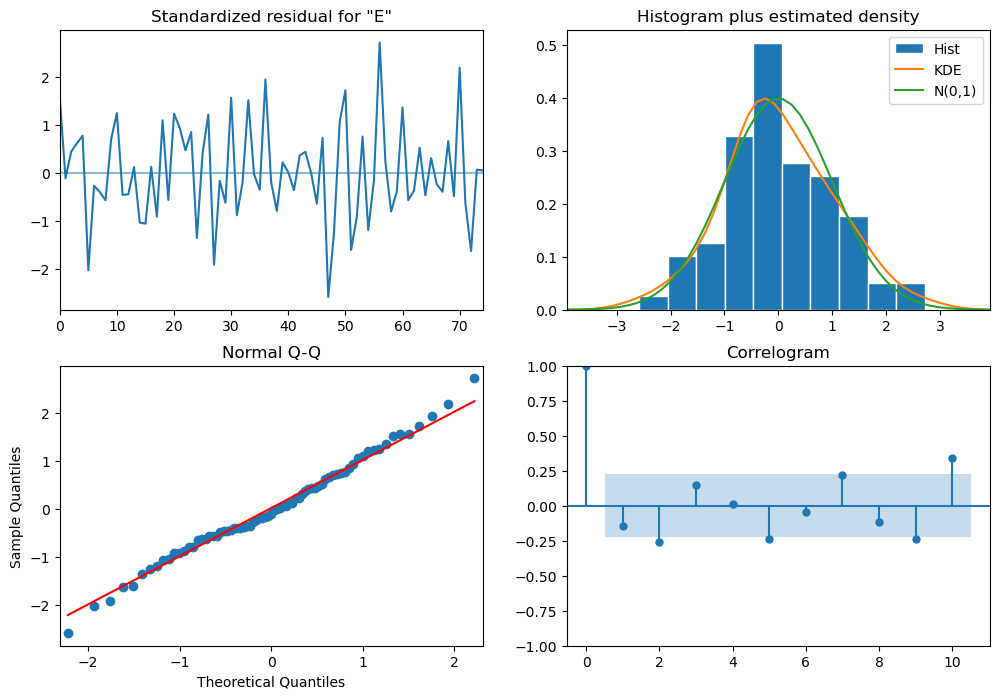

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMAX model
model = SARIMAX(train.dropna(),
                order=(1, 1, 0),                # ARIMA terms
                seasonal_order=(1, 0, 0, 4),     # Quarterly seasonality
                exog=exog_train)                 # Include differenced independent variables

result = model.fit()

# Display model summary
print(result.summary())

# Plot residual diagnostics
result.plot_diagnostics(figsize=(12, 8))
plt.show()


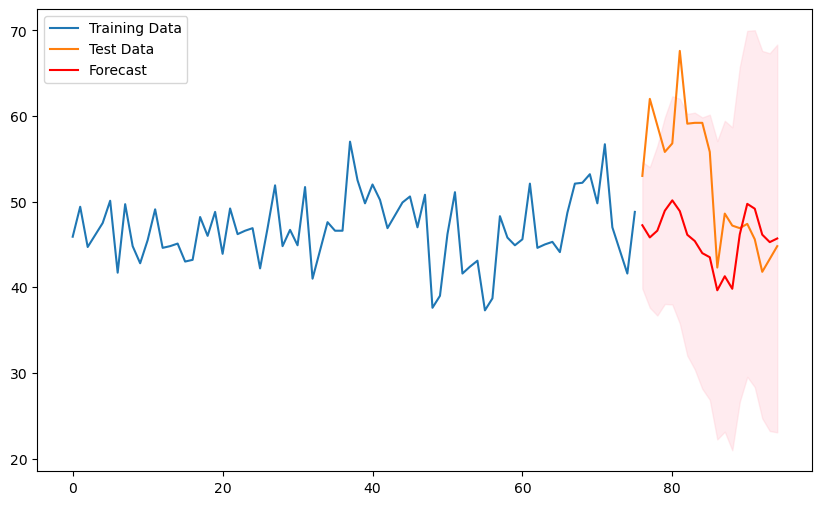

In [34]:
# Forecast using the test set
forecast = result.get_forecast(steps=len(test), exog=exog_test)
forecast_ci = forecast.conf_int()

# Plot forecast vs actual
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()


In [36]:
print(result.summary())
# Reduce Independent Variables Based on p-Values
# Remove variables with p > 0.05 (not statistically significant)

                                     SARIMAX Results                                     
Dep. Variable:               Excellent_Very_Good   No. Observations:                   76
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 4)   Log Likelihood                -206.240
Date:                           Tue, 01 Apr 2025   AIC                            438.481
Time:                                   17:18:08   BIC                            468.608
Sample:                                        0   HQIC                           450.510
                                            - 76                                         
Covariance Type:                             opg                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Quarterly Sum Precip (mm)_diff              0.2019      0.489   

In [38]:
import os

# Ensure output directory exists
output_dir = '../data/processed/'
os.makedirs(output_dir, exist_ok=True)

# Combine actuals: training + test
full_actual = pd.concat([train, test])
full_actual.name = 'Actual'

# Combine training + forecast
forecast_series = forecast.predicted_mean
full_predicted = pd.concat([train, forecast_series])
full_predicted.name = 'Actual + Forecast'

# Combine into one DataFrame
export_combined = pd.DataFrame({
    'Actual': full_actual,
    'Predicted': full_predicted
})

# Optional: Add confidence intervals for predicted portion
export_combined['Lower_CI'] = pd.concat([pd.Series([None] * len(train), index=train.index), forecast_ci.iloc[:, 0]])
export_combined['Upper_CI'] = pd.concat([pd.Series([None] * len(train), index=train.index), forecast_ci.iloc[:, 1]])

# Export to CSV
export_combined.to_csv(os.path.join(output_dir, 'sarima_actual_vs_forecast_all_inde_excellent_very_good.csv'))

print("Export completed: '../data/processed/sarima_actual_vs_forecast_all_inde_excellent_very_good.csv'")


Export completed: '../data/processed/sarima_actual_vs_forecast_all_inde_excellent_very_good.csv'


### Adjust SARIMA with less independent variables

In [41]:
# Keep only the significant independent variables:

exog_vars = [
    'Depression_diff',
    'Anxiety_diff',
    'Stress_diff',
    'Quarterly Avg Temp (°C)_diff'
]
exog_train = df[exog_vars].iloc[:train_size]
exog_test = df[exog_vars].iloc[train_size:]


In [43]:
# Drop Seasonal Term Since p > 0.05:

model = SARIMAX(train.dropna(),
                order=(1, 1, 0),                # ARIMA terms
                seasonal_order=(0, 0, 0, 4),     # Drop seasonal terms
                exog=exog_train)                 # Reduced exogenous variables


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75391D+00    |proj g|=  1.04154D-02

At iterate    5    f=  2.73878D+00    |proj g|=  1.34983D-02

At iterate   10    f=  2.73568D+00    |proj g|=  4.29503D-04

At iterate   15    f=  2.73567D+00    |proj g|=  1.19353D-04

At iterate   20    f=  2.73567D+00    |proj g|=  1.66326D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     24      1     0     0   4.257D-06   2.736D+00
  F =   2.7356678731190893     

CONVERG

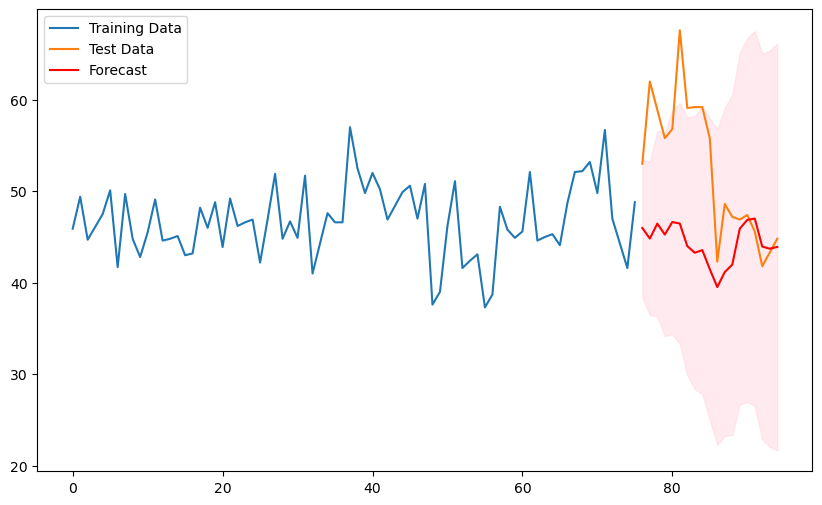

In [45]:
result = model.fit()
print(result.summary())

forecast = result.get_forecast(steps=len(test), exog=exog_test)
forecast_ci = forecast.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()


### Update SARIMAX Setup
### Keep AR term at (1, 1, 0) → Already responsive to long-term patterns
### Add MA term → (1, 1, 1) → Improve short-term accuracy

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67787D+00    |proj g|=  4.08350D-02

At iterate    5    f=  2.66479D+00    |proj g|=  1.55052D-02

At iterate   10    f=  2.65791D+00    |proj g|=  2.15782D-03

At iterate   15    f=  2.65736D+00    |proj g|=  1.06300D-03

At iterate   20    f=  2.65718D+00    |proj g|=  9.23801D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     27      1     0     0   1.204D-05   2.657D+00
  F =   2.6571774284278260     

CONVERG

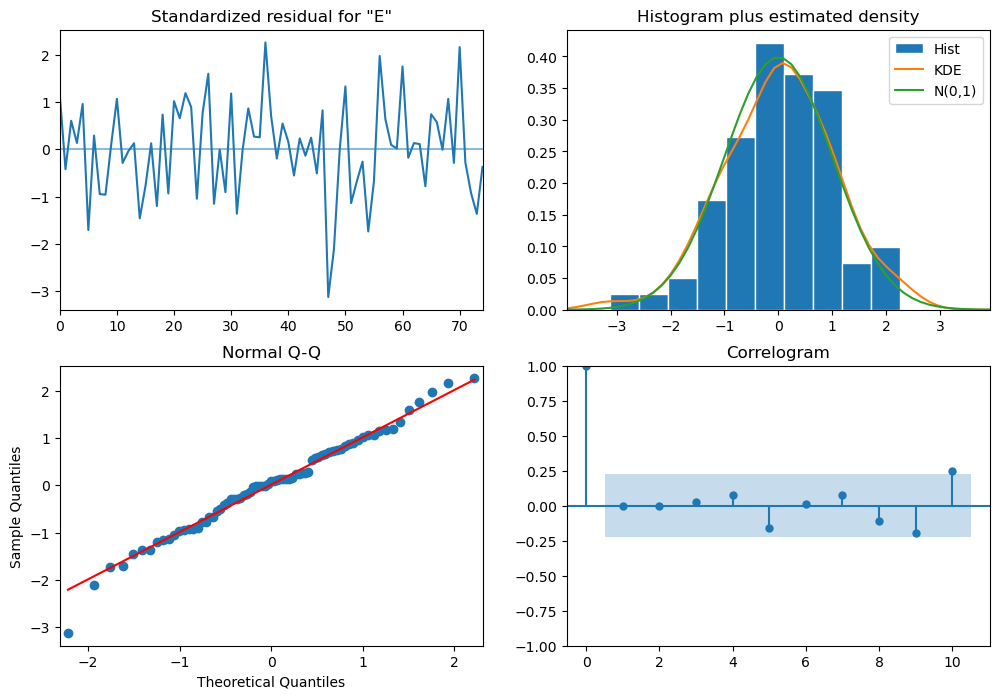

In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Updated independent variables
exog_vars = [
    'Depression_diff',
    'Anxiety_diff',
    'Stress_diff',
    'Quarterly Avg Temp (°C)_diff'
]

exog_train = df[exog_vars].iloc[:train_size]
exog_test = df[exog_vars].iloc[train_size:]

# Fit SARIMAX model
model = SARIMAX(train.dropna(),
                order=(1, 1, 1),                 # Add MA term
                seasonal_order=(0, 0, 0, 4),      # Keep quarterly seasonality
                exog=exog_train)                  # Include independent variables

result = model.fit()

# Display model summary
print(result.summary())

# Plot residual diagnostics
result.plot_diagnostics(figsize=(12, 8))
plt.show()


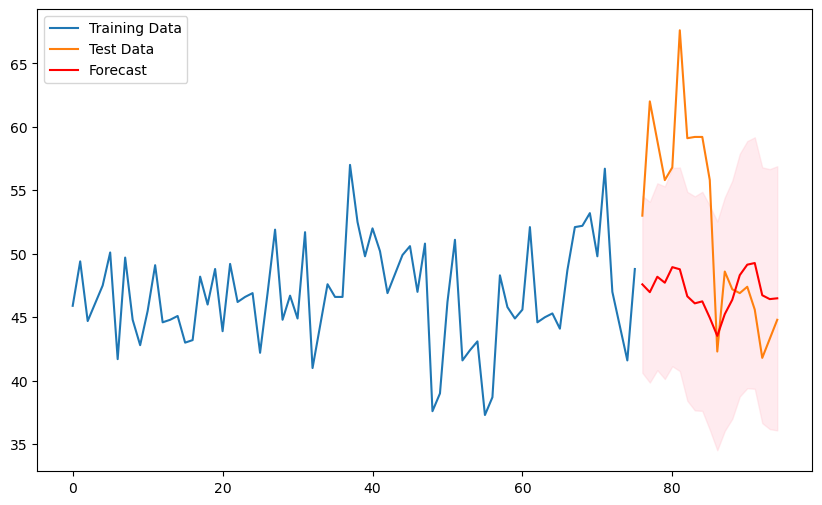

In [50]:
forecast = result.get_forecast(steps=len(test), exog=exog_test)
forecast_ci = forecast.conf_int()

# Plot forecast vs actual
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()


In [52]:
import os
import pandas as pd

# Create the output directory if it doesn't exist
output_dir = '../data/processed/'
os.makedirs(output_dir, exist_ok=True)

# Combine actuals: training + test
full_actual = pd.concat([train, test])
full_actual.name = 'Actual'

# Combine training + forecast
forecast_series = forecast.predicted_mean
full_predicted = pd.concat([train, forecast_series])
full_predicted.name = 'Actual + Forecast'

# Create combined DataFrame
export_combined = pd.DataFrame({
    'Actual': full_actual,
    'Predicted': full_predicted
})

# Add confidence intervals (only for forecast portion)
export_combined['Lower_CI'] = pd.concat([
    pd.Series([None] * len(train), index=train.index),
    forecast_ci.iloc[:, 0]
])
export_combined['Upper_CI'] = pd.concat([
    pd.Series([None] * len(train), index=train.index),
    forecast_ci.iloc[:, 1]
])

# Export to CSV
export_path = os.path.join(output_dir, 'sarima_actual_vs_forecast_partial_inde_excellent_very_good.csv')
export_combined.to_csv(export_path)

print(f"✅ Export completed: '{export_path}'")


✅ Export completed: '../data/processed/sarima_actual_vs_forecast_partial_inde_excellent_very_good.csv'
